<a href="https://colab.research.google.com/github/juanpheusser/BERTutor-AC209b/blob/main/Milestone_4_BERTutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone 4#

Group Members: Udayan Bulchandani, Juan Pablo Heusser, Curren Iyer.

Group: 13

# Problem Statement Refinement #

After researching BERT and VisualBERT more extensively, we realized that the model is not capable (nor is it built with this goal) to generate text. And so we changed our problem statement to fine-tune a pretrained VisualBert model for multiple choice question answering, where the model is fed with ([question, image], answer choice) pairs, and the model returns the probability for each choice to be the correct one.

In terms of significance, it certainly impacts our goal of helping K-12 students learn science, but it can still become a great study tool to help students work through practice problem sets.


# Comprehensive EDA Review#

##Dataset Description##

We will be using the ScienceQA dataset which is accesible via Hugging Face via the following link:

https://huggingface.co/datasets/derek-thomas/ScienceQA

The dataset contains 21,208 questions multimodal multiple-choice science questions of elementary and high school level. The following metrics are available in the dataset's description, which we will check in this notebook:

 - Questions with image context: 48.7%
 - Questions with text context: 48.2%
 - Questions with both image and text context: 30.8%

 The dataset is split into training and test datasets. The training dataset has 12,726 data points (60%) and the test dataset has 4,241 datapoints (40%).

 The dataset has the following variables (columns):

  - image: The contextual image to answer the question

    - dictionary('bytes': byte)

  - question: Question prompt

    - string

  - choices: Multiple choice answers with, where only 1 option is correct

    - list(string, ...)

  - answer: Index of the choice corresponding to the correct answer

    - integer - one of [0,1,2,3,4]

  - hint: A helpful hint to answer the question

    - string

  - task: A description of the task that the student needs to solve

    - string - one of ['closed choice', 'yes or no', 'true-or false']

  - grade: Grade level from K to 12

    - string - one of ['grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6',
       'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']

  - subject: The school subject to which the question belongs

    - string - one of ['social science', 'natural science', 'language science']

  - topic: a subcategory of subject

    - string - one of ['geography', 'science-and-engineering-practices', 'verbs',
       'chemistry', 'writing-strategies', 'biology', 'physics',
       'units-and-measurement', 'figurative-language', 'economics',
       'reference-skills', 'phonological-awareness', 'grammar',
       'earth-science', 'punctuation', 'capitalization', 'us-history',
       'reading-comprehension', 'world-history', 'civics', 'vocabulary',
       'literacy-in-science', 'word-study', 'culture', 'pronouns',
       'global-studies']

  - category: A subcategory of topic

    - string

  - skill: The skill being tested by the question

    - string

  - lecture: Lecture summary from where the question was pulled

    - string

  - solution: Text explanation of the solution to the question

    - string


###Initial Imports and Data Loading###

In [1]:
%%capture
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  !apt-get install git
  !git clone https://github.com/juanpheusser/BERTutor-AC209b.git
  !pip install datasets
  !pip install evaluate
  !pip install accelerate
  !pip install --upgrade huggingface_hub
  !pip install torchview
  !pip install pyyaml==5.1
  !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

  sys.path.append('/content/BERTutor-AC209b')

  print('Google Drive mounter at /content/drive')

else:
  print('Not running on Google Colab')

In [2]:
# Module Imports
from collections import Counter
from datasets import load_dataset
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from tqdm import tqdm
import gc

# Custom Util Module Imports
from visual_embeds import GetVisualEmbeddings

In [3]:
# Load dataset
dataset = load_dataset('derek-thomas/ScienceQA')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [4]:
# Separate train and test data
train_data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()
validation_data = dataset['validation'].to_pandas()

print(f'Shape of train data: {train_data.shape}')
print(f'Shape of test data: {test_data.shape}')
print(f'Shape of validation data: {validation_data.shape}')

Shape of train data: (12726, 13)
Shape of test data: (4241, 13)
Shape of validation data: (4241, 13)


In [ ]:
# Inspect data
train_data.head()

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which of these states is farthest north?,"[West Virginia, Louisiana, Arizona, Oklahoma]",0,,closed choice,grade2,social science,geography,Geography,Read a map: cardinal directions,"Maps have four cardinal directions, or main di...","To find the answer, look at the compass rose. ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Identify the question that Tom and Justin's ex...,[Do ping pong balls stop rolling along the gro...,1,The passage below describes an experiment. Rea...,closed choice,grade8,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Identify the question that Kathleen and Bryant...,[Does Kathleen's snowboard slide down a hill i...,0,The passage below describes an experiment. Rea...,closed choice,grade7,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,
3,None,Which tense does the sentence use?\nMona will ...,"[present tense, future tense, past tense]",1,,closed choice,grade2,language science,verbs,Verb tense,"Is the sentence in the past, present, or futur...",Present tense verbs tell you about something t...,The sentence is in future tense. You can tell ...
4,None,Complete the sentence.\nSewing an apron is a ().,"[chemical change, physical change]",1,,closed choice,grade4,natural science,chemistry,Physical and chemical change,Identify physical and chemical changes,Chemical changes and physical changes are two ...,Sewing an apron is a physical change. The fabr...


### Visualizing an Example Image###


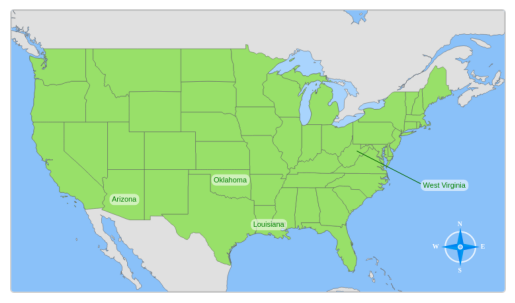

In [ ]:
# Visualize a single image
image_bytes = train_data.loc[0, 'image']['bytes']
image = Image.open(BytesIO(image_bytes))

plt.imshow(image)
plt.axis('off')
plt.show()

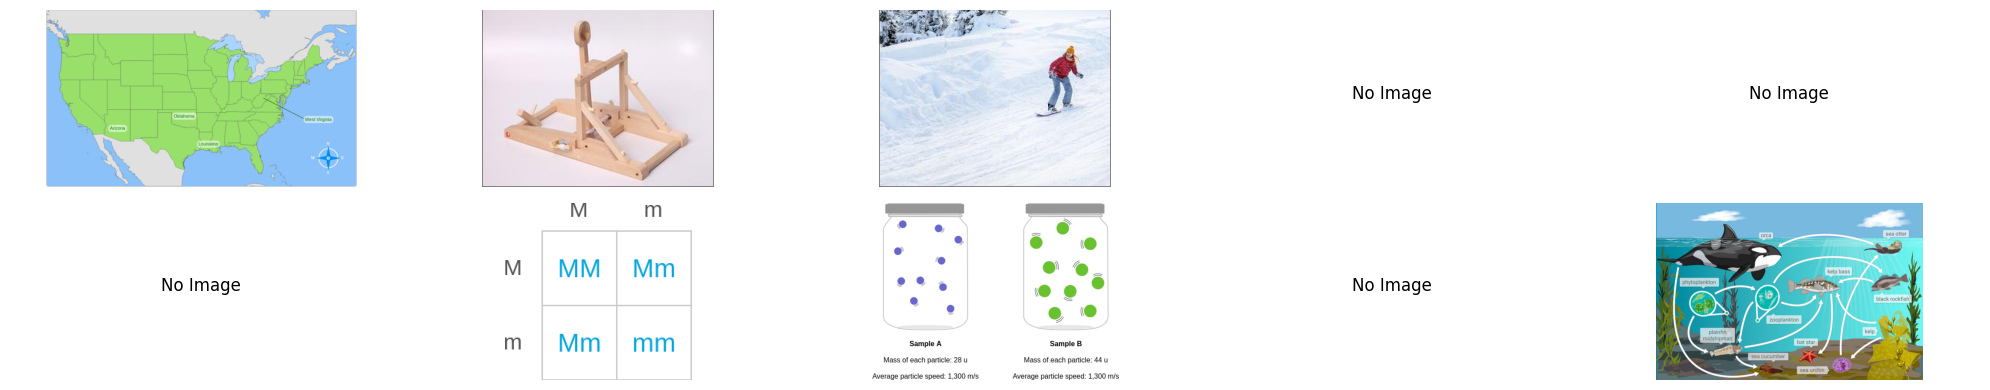

In [ ]:
# Visualize images of ten first rows
fig, axes = plt.subplots(2, 5, figsize=(20, 4))
axes = axes.flatten()

for i, (index, row) in enumerate(train_data.head(10).iterrows()):
    image_bytes = row['image']
    if image_bytes is not None:
        image = Image.open(BytesIO(image_bytes['bytes']))
        axes[i].imshow(image)
    else:
        axes[i].text(0.5, 0.5, 'No Image', fontsize=12, ha='center')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Finding Missing Values

From a first glance, it seems that only image values are missing for almost 49% of the datapoints.

In [ ]:
# Inspect train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12726 entries, 0 to 12725
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6218 non-null   object
 1   question  12726 non-null  object
 2   choices   12726 non-null  object
 3   answer    12726 non-null  int8  
 4   hint      12726 non-null  object
 5   task      12726 non-null  object
 6   grade     12726 non-null  object
 7   subject   12726 non-null  object
 8   topic     12726 non-null  object
 9   category  12726 non-null  object
 10  skill     12726 non-null  object
 11  lecture   12726 non-null  object
 12  solution  12726 non-null  object
dtypes: int8(1), object(12)
memory usage: 1.2+ MB


But on deeper exploration, there are empty string values some of the columns.

```
x = ''
```

So we replaced each empty string value for None, so that they are easy to identify.



In [ ]:
# Replace empty string values for None
columns_to_check = ['question', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

train_data[columns_to_check] = train_data[columns_to_check].applymap(lambda x: None if x == '' else x)
test_data[columns_to_check] = test_data[columns_to_check].applymap(lambda x: None if x == '' else x)



In [ ]:
# Inspect train data with replaced values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12726 entries, 0 to 12725
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6218 non-null   object
 1   question  12726 non-null  object
 2   choices   12726 non-null  object
 3   answer    12726 non-null  int64 
 4   hint      6079 non-null   object
 5   task      12726 non-null  object
 6   grade     12726 non-null  object
 7   subject   12726 non-null  object
 8   topic     12726 non-null  object
 9   category  12726 non-null  object
 10  skill     12726 non-null  object
 11  lecture   10692 non-null  object
 12  solution  11515 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.3+ MB


In [ ]:
# Inspect test data with replaced values
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4241 entries, 0 to 4240
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     2017 non-null   object
 1   question  4241 non-null   object
 2   choices   4241 non-null   object
 3   answer    4241 non-null   int64 
 4   hint      2046 non-null   object
 5   task      4241 non-null   object
 6   grade     4241 non-null   object
 7   subject   4241 non-null   object
 8   topic     4241 non-null   object
 9   category  4241 non-null   object
 10  skill     4241 non-null   object
 11  lecture   3532 non-null   object
 12  solution  3839 non-null   object
dtypes: int64(1), object(12)
memory usage: 430.9+ KB


### Data Imbalance

We now consider the level of imbalance in our dataset. We examine only the following categorical variables: grade, subject, topic and category. Histograms for each are shown below.

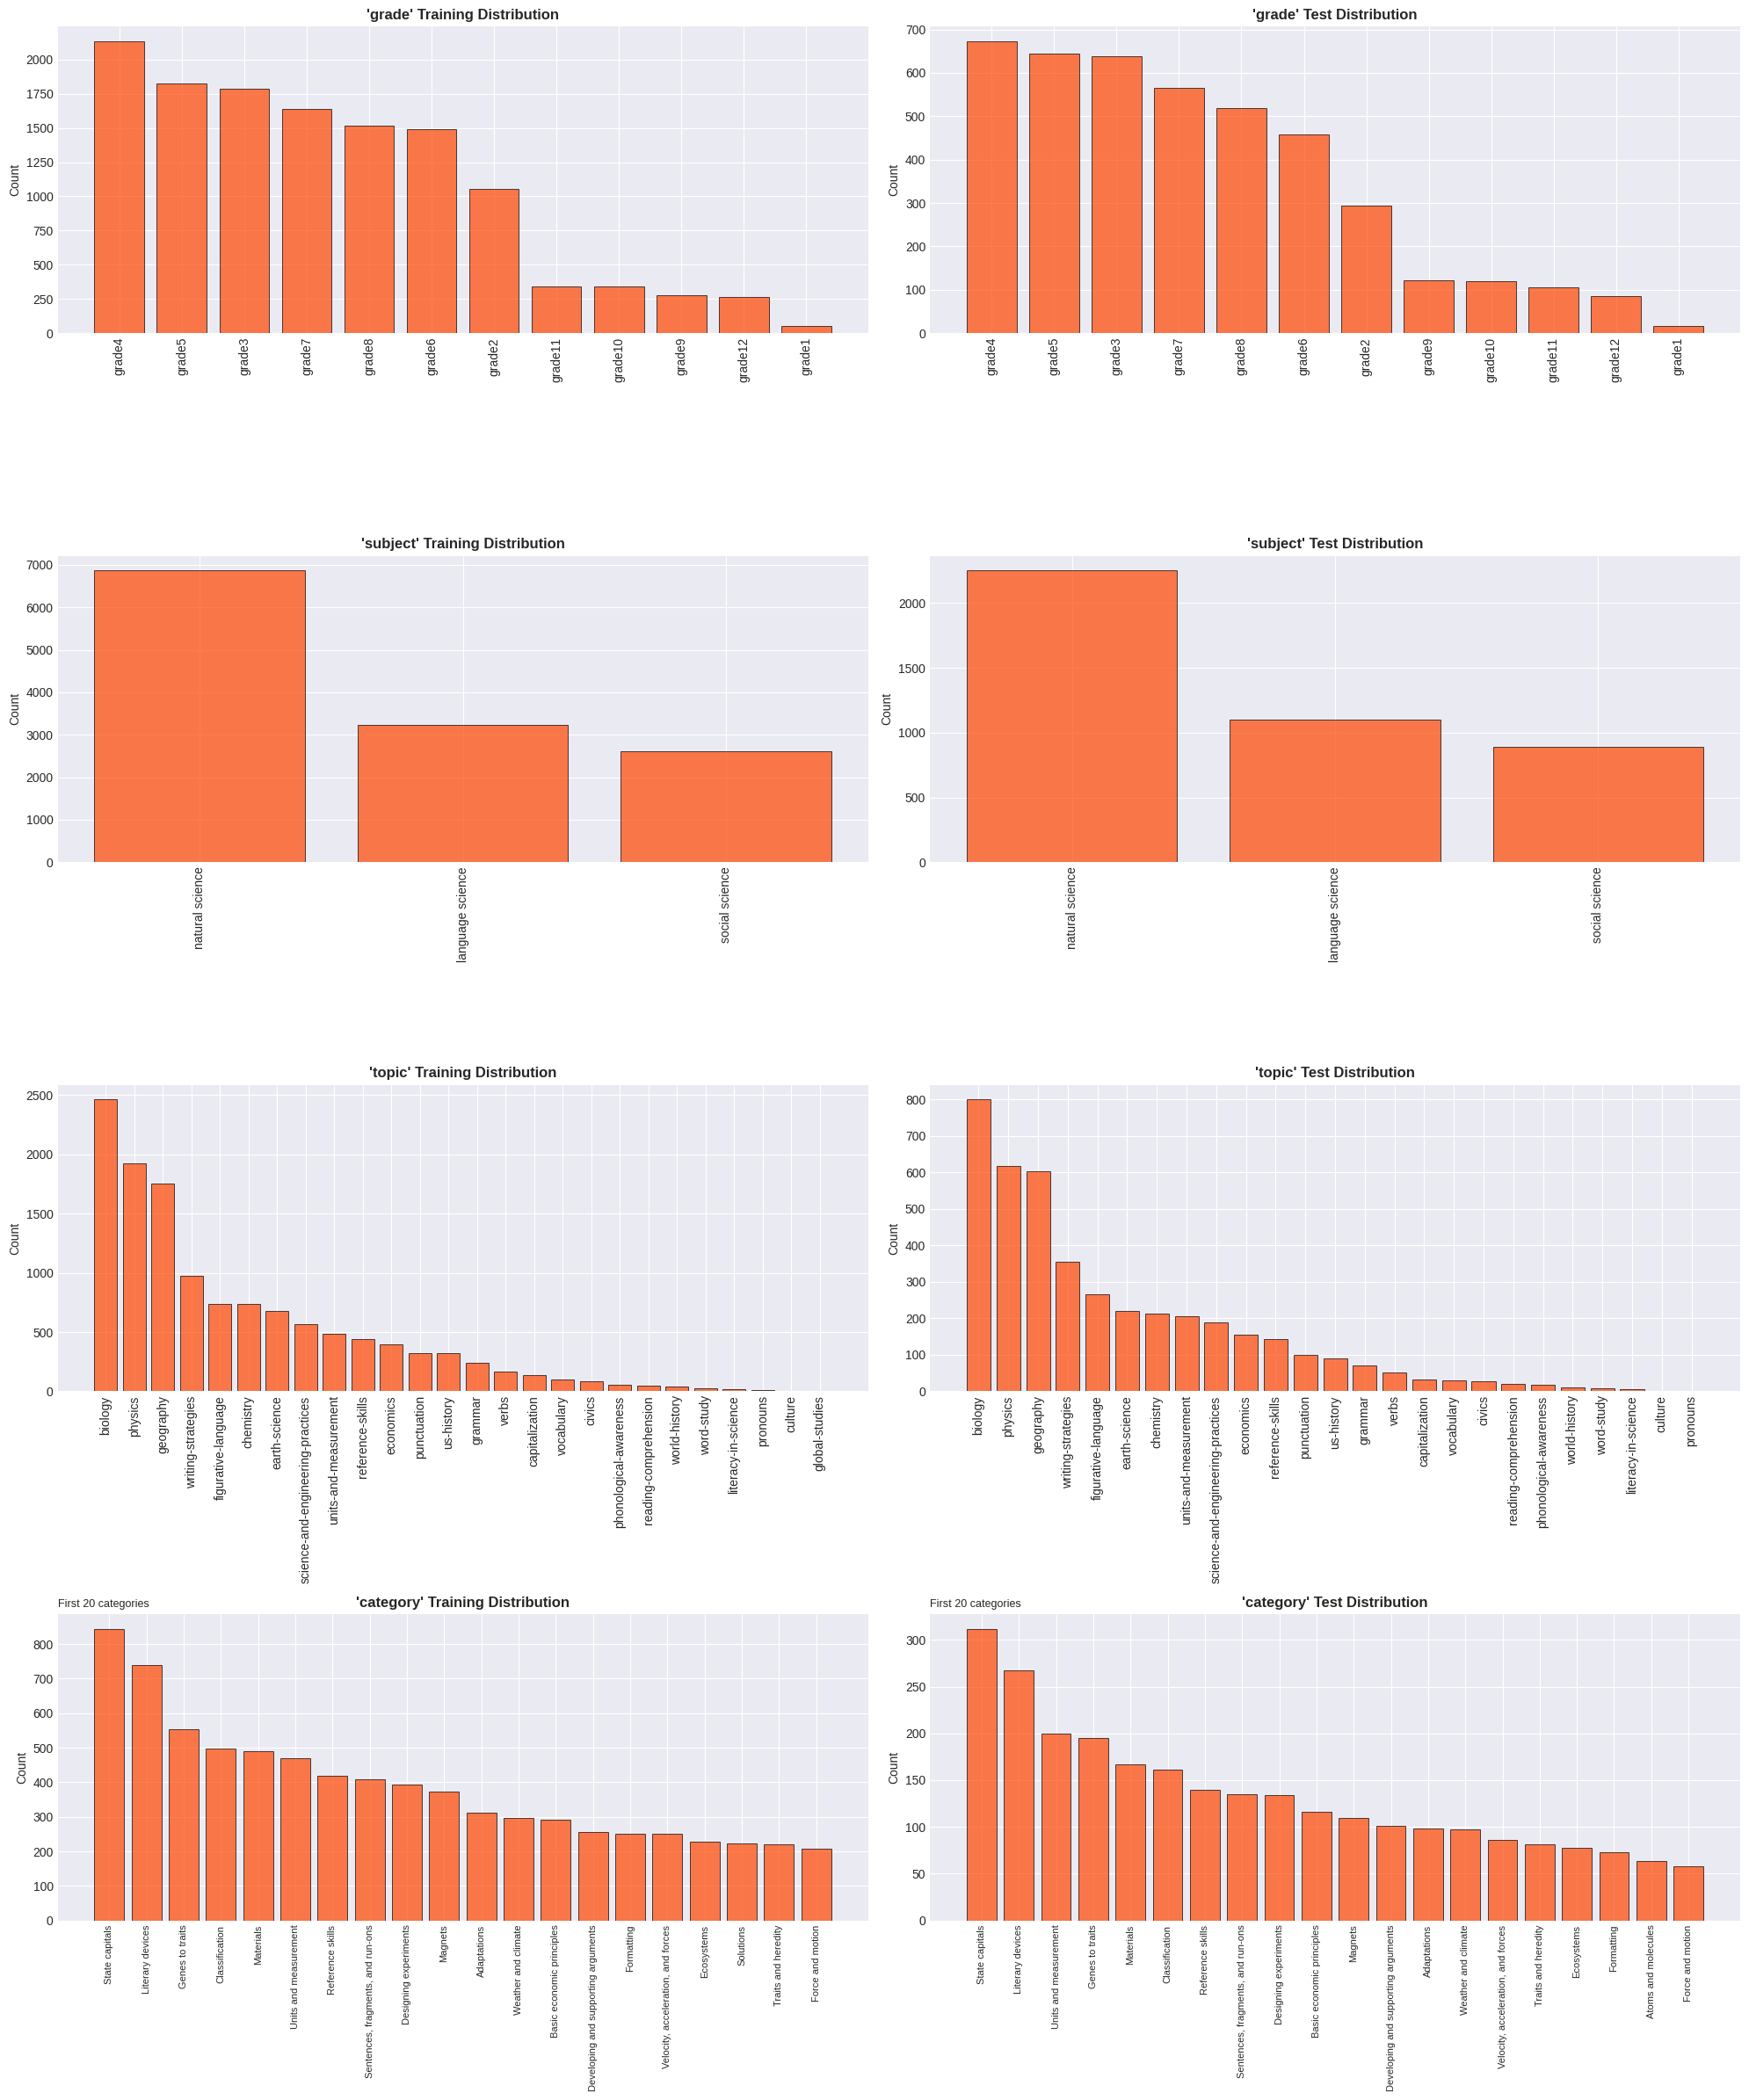

In [ ]:
def plot_histogram(values, axis, small_fonts):
    counts = Counter(values)
    common = counts.most_common()
    labels = [item[0] for item in common]
    number = [item[1] for item in common]
    nbars = len(common)
    if small_fonts:
        axis.bar(np.arange(nbars)[:20], number[:20], tick_label=labels[:20], edgecolor='black', linewidth=.7, color='orangered', alpha=0.7)
        axis.set_title('First 20 categories', loc='left', fontsize=9)
        axis.set_xticklabels(labels[:20], rotation=90, fontsize = 8)
    else:
        axis.bar(np.arange(nbars), number, tick_label=labels, edgecolor='black', linewidth=.7, color='orangered', alpha=0.7)
        axis.set_xticklabels(labels, rotation=90)

columns_to_check = ['grade', 'subject', 'topic', 'category']
plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(4, 2, figsize=(20, 24))
axes = axes.flatten()


for i, column_name in enumerate(columns_to_check):
    train_column = train_data[column_name].values
    train_axis = axes[i*2]
    plot_histogram(train_column, train_axis, column_name == 'category')
    train_axis.set_title(f'\'{column_name}\' Training Distribution', fontweight='bold')
    train_axis.set_ylabel('Count')

    test_column = test_data[column_name].values
    test_axis = axes[i*2+1]
    plot_histogram(test_column, test_axis, column_name == 'category')
    test_axis.set_title(f'\'{column_name}\' Test Distribution', fontweight='bold')
    test_axis.set_ylabel('Count')



plt.tight_layout()
plt.show()

With the exception of subject, these are all somewhat concerning. For topic, grade, and particularly category, each distribution has significant tails - meaning there are many feature values captured by as few as one data point.

For grade, this is likely not a problem, as the grade feature is unlikely to important. Simply bucketing the underrepresented grade ('grade1') into an adjacent category ('grade2') could help.

Topic is more challenging. Perhaps a separate classifier could be built to generate topic labels for each datapoint, which seems like a tractable problem. However, as with grade, the topic feature is unlikely to be relevant.

Finally, category. This is the most challenging to address - it has the most pronounced tail, and there is no clear way to synthesize or group data. However, once again, this feature is unlikely to be relevant to our learned model.

## Constructing Features

### Preprocessing for Multiple Choice

Each row in the ScienceQA dataset has a 'question' field, which contains question text, and a 'choices' field, which contains a variable length list of multiple choice answers.

Bert models handle multiple choice questions by taking in a tokenized pair of sentences, divided the by '[SEP]' token, and generate a binary prediction of whether the second follows the first.

So, we have to convert our multiple choice dataset to sentence pairs. We will end up with one question/answer pair for each multiple choice answer in the original ScienceQA dataset.

Note that questions in the ScienceQA dataset have varying number of multiple choice answers. For batch processing, we need a consistent number of answers for each question, so we pad our dataset with empty answers.

In [5]:
MAX_CHOICES = 5

def preprocess_function(data):

    # Tokenize question/answer pairs

    first_sentences = []
    second_sentences = []
    tokens = {}

    questions = [ [question] * MAX_CHOICES for question in data['question'] ]
    answers = [ list(choices) + ['']*(MAX_CHOICES-len(choices)) for choices in data["choices"] ]

    # The previous lines return lists of lists, so flatten them
    questions = sum(questions, [])
    answers = sum(answers, [])

    tokenized_examples = tokenizer(questions, answers, truncation=True)

    # Generate visual embeddings

    # Get indicies of null and non-null images
    # get a list of images (this may need its own batching hm..)
    # pass them to the pipeline
    # repopulate the '

    # unflatten the reuslts
    return {k: [v[i : i + MAX_CHOICES] for i in range(0, len(v), MAX_CHOICES)] for k, v in tokenized_examples.items()}

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenized_dataset = dataset['train'].take(5).map(preprocess_function, batched = True)
print(tokenized_dataset[4]['question'])
print(tokenized_dataset[4]['choices'])
print(tokenized_dataset[4]['hint'])
for candidate in tokenized_dataset[4]['input_ids']:
  print(tokenizer.decode(candidate))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Complete the sentence.
Sewing an apron is a ().
['chemical change', 'physical change']

[CLS] complete the sentence. sewing an apron is a ( ). [SEP] chemical change [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] physical change [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]


In [12]:
from transformers import AutoTokenizer
tokenized_dataset = dataset.map(preprocess_function, batched = True)

## Hugginface models expect the label column name
tokenized_dataset = tokenized_dataset.rename_column("answer", "label")

# Visual Embeddings

## Generate Embeddings

To be able to process images as inputs, the model needs to use a vision model. Based on the Huggingface documentation for VisualBert, we will use the Detectron2 library. From this library we will use the MaskRCNN ResNet-101 FPN model which has been pre-trained on the COCO (Common Objects in Context) dataset.


In [9]:
import torch
torch.__version__
cuda = torch.cuda.is_available()
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
ve = GetVisualEmbeddings(cfg_path, cuda=True)


model_final_a3ec72.pkl: 254MB [00:01, 236MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
batch_size = 5
train_data['batch'] = np.arange(0, len(train_data)) // batch_size
i = 0

for _, batch in tqdm(train_data.groupby('batch')):

  try:
    batch_visual_embeddings = ve.get_visual_embeddings(batch, save=True, filepath='drive/MyDrive/visual_embeds/visual_embeds_'+ str(i) + '.pt')
    del batch_visual_embeddings
    gc.collect()
    torch.cuda.empty_cache()
  except RuntimeError as e:
    print(e)

  i += 1



  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  0%|          | 0/2546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-7-2e04216fa7a7>:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keep = torch.tensor(nms(det_boxes, cls_scores, test_nms_thresh))
  1%|          | 18/2546 [00:38<1:19:47,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5114880


  2%|▏         | 42/2546 [01:30<1:24:54,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5035008


  3%|▎         | 83/2546 [02:56<1:21:44,  1.99s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


  4%|▍         | 108/2546 [03:49<1:20:14,  1.97s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


  5%|▌         | 136/2546 [04:49<1:18:51,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5097472


  6%|▋         | 161/2546 [05:41<1:15:46,  1.91s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5115904


  7%|▋         | 186/2546 [06:32<1:10:14,  1.79s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5094400


  7%|▋         | 189/2546 [06:38<1:13:37,  1.87s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 10%|█         | 256/2546 [08:58<1:09:36,  1.82s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5097472


 10%|█         | 261/2546 [09:07<1:05:37,  1.72s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 11%|█         | 272/2546 [09:28<1:13:29,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5006336


 13%|█▎        | 321/2546 [11:09<1:14:44,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5075968


 15%|█▍        | 372/2546 [12:56<1:12:11,  1.99s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 15%|█▍        | 380/2546 [13:12<1:10:43,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5082112


 16%|█▋        | 414/2546 [14:22<1:07:34,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5050368


 16%|█▋        | 417/2546 [14:28<1:12:05,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5076992


 18%|█▊        | 457/2546 [15:50<1:08:41,  1.97s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 19%|█▉        | 488/2546 [16:55<1:03:35,  1.85s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5109760


 19%|█▉        | 493/2546 [17:04<1:01:59,  1.81s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5053440


 20%|██        | 516/2546 [17:52<1:07:53,  2.01s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5116928


 20%|██        | 521/2546 [18:03<1:05:17,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5116928


 21%|██        | 531/2546 [18:23<1:06:04,  1.97s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 22%|██▏       | 555/2546 [19:12<59:52,  1.80s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5115904


 23%|██▎       | 581/2546 [20:04<1:05:54,  2.01s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 23%|██▎       | 585/2546 [20:12<1:04:51,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 24%|██▎       | 603/2546 [20:49<58:58,  1.82s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5116928


 24%|██▍       | 622/2546 [21:28<55:38,  1.74s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5097472


 25%|██▍       | 629/2546 [21:42<58:13,  1.82s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5090304


 29%|██▊       | 729/2546 [25:14<52:48,  1.74s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5115904


 29%|██▊       | 731/2546 [25:17<50:50,  1.68s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5118976


 30%|███       | 767/2546 [26:34<54:10,  1.83s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5113856


 31%|███       | 789/2546 [27:19<52:16,  1.78s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5084160


 32%|███▏      | 823/2546 [28:29<53:17,  1.86s/it]  

shape '[-1, 1000, 512]' is invalid for input of size 5068800


 33%|███▎      | 843/2546 [29:10<50:16,  1.77s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5043200


 34%|███▍      | 872/2546 [30:09<54:04,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4980736


 35%|███▍      | 888/2546 [30:41<53:41,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 35%|███▌      | 893/2546 [30:52<55:12,  2.00s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 36%|███▌      | 919/2546 [31:44<53:35,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5008384


 38%|███▊      | 958/2546 [33:05<49:05,  1.86s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5098496


 38%|███▊      | 977/2546 [33:44<51:18,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 39%|███▊      | 981/2546 [33:53<52:49,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5113856


 41%|████      | 1036/2546 [35:44<47:17,  1.88s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5101568


 41%|████      | 1043/2546 [35:58<48:05,  1.92s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4958208


 41%|████      | 1047/2546 [36:05<42:46,  1.71s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5104640


 41%|████▏     | 1051/2546 [36:13<41:28,  1.66s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 42%|████▏     | 1059/2546 [36:28<44:58,  1.81s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 43%|████▎     | 1093/2546 [37:38<45:00,  1.86s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5067776


 44%|████▍     | 1119/2546 [38:33<48:34,  2.04s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 44%|████▍     | 1124/2546 [38:43<44:47,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4971520


 46%|████▌     | 1177/2546 [40:32<44:24,  1.95s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 47%|████▋     | 1197/2546 [41:15<46:43,  2.08s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 49%|████▉     | 1250/2546 [43:02<44:07,  2.04s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 49%|████▉     | 1259/2546 [43:20<41:30,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 50%|████▉     | 1272/2546 [43:48<43:36,  2.05s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 50%|█████     | 1274/2546 [43:51<40:55,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 50%|█████     | 1275/2546 [43:53<40:12,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5043200


 53%|█████▎    | 1350/2546 [46:29<38:48,  1.95s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5010432


 53%|█████▎    | 1355/2546 [46:40<39:26,  1.99s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 53%|█████▎    | 1359/2546 [46:48<40:15,  2.04s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 53%|█████▎    | 1361/2546 [46:51<36:24,  1.84s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5065728


 54%|█████▍    | 1375/2546 [47:21<39:02,  2.00s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4916224


 55%|█████▍    | 1393/2546 [47:59<37:05,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5063680


 57%|█████▋    | 1448/2546 [49:54<37:37,  2.06s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4986880


 58%|█████▊    | 1477/2546 [50:54<31:57,  1.79s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5114880


 59%|█████▉    | 1499/2546 [51:39<34:36,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4962304


 60%|██████    | 1536/2546 [52:54<32:47,  1.95s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5083136


 61%|██████    | 1541/2546 [53:04<29:52,  1.78s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5094400


 65%|██████▌   | 1662/2546 [57:12<29:14,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 65%|██████▌   | 1667/2546 [57:22<28:57,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 66%|██████▋   | 1687/2546 [58:01<25:34,  1.79s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5115904


 67%|██████▋   | 1696/2546 [58:19<24:28,  1.73s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 67%|██████▋   | 1714/2546 [58:55<26:45,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 69%|██████▉   | 1768/2546 [1:00:43<22:24,  1.73s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5103616


 70%|██████▉   | 1777/2546 [1:01:01<24:05,  1.88s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 71%|███████▏  | 1819/2546 [1:02:27<24:31,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4987904


 72%|███████▏  | 1826/2546 [1:02:40<21:23,  1.78s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5103616


 73%|███████▎  | 1864/2546 [1:03:58<22:01,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 75%|███████▍  | 1897/2546 [1:05:06<20:36,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5105664


 75%|███████▍  | 1898/2546 [1:05:07<18:04,  1.67s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5117952


 75%|███████▌  | 1911/2546 [1:05:32<18:36,  1.76s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5116928


 78%|███████▊  | 1982/2546 [1:07:59<18:52,  2.01s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 78%|███████▊  | 1994/2546 [1:08:23<17:16,  1.88s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 80%|████████  | 2039/2546 [1:09:55<15:03,  1.78s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5115904


 86%|████████▌ | 2188/2546 [1:15:07<10:31,  1.76s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5096448


 87%|████████▋ | 2222/2546 [1:16:17<10:08,  1.88s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 89%|████████▊ | 2259/2546 [1:17:35<08:06,  1.69s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5113856


 89%|████████▉ | 2272/2546 [1:18:02<09:15,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4990976


 90%|█████████ | 2296/2546 [1:18:54<08:39,  2.08s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 91%|█████████▏| 2329/2546 [1:20:05<06:49,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5006336


 92%|█████████▏| 2341/2546 [1:20:31<06:25,  1.88s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 92%|█████████▏| 2342/2546 [1:20:32<05:47,  1.70s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5111808


 94%|█████████▍| 2390/2546 [1:22:16<05:14,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5027840


 95%|█████████▌| 2424/2546 [1:23:30<04:11,  2.06s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5101568


 96%|█████████▌| 2437/2546 [1:23:57<03:19,  1.83s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 96%|█████████▌| 2440/2546 [1:24:03<03:20,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 96%|█████████▌| 2443/2546 [1:24:09<03:19,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 97%|█████████▋| 2470/2546 [1:25:07<02:35,  2.05s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5035008


 97%|█████████▋| 2472/2546 [1:25:11<02:29,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5013504


 97%|█████████▋| 2473/2546 [1:25:13<02:22,  1.95s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 98%|█████████▊| 2499/2546 [1:26:09<01:30,  1.92s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5091328


 99%|█████████▊| 2511/2546 [1:26:34<01:07,  1.92s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5117952


100%|██████████| 2546/2546 [1:27:49<00:00,  2.07s/it]


In [ ]:
batch_size = 5
test_data['batch'] = np.arange(0, len(test_data)) // batch_size
i = 0

for _, batch in tqdm(test_data.groupby('batch')):

  try:
    batch_visual_embeddings = ve.get_visual_embeddings(batch, save=True, filepath='drive/MyDrive/visual_embeds/visual_embeds_test_'+ str(i) + '.pt')
    del batch_visual_embeddings
    gc.collect()
    torch.cuda.empty_cache()
  except RuntimeError as e:
    print(e)

  i += 1


  0%|          | 0/849 [00:00<?, ?it/s]<ipython-input-7-2e04216fa7a7>:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keep = torch.tensor(nms(det_boxes, cls_scores, test_nms_thresh))
  1%|▏         | 12/849 [00:23<25:38,  1.84s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


  4%|▍         | 35/849 [01:09<25:49,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5106688


  6%|▌         | 50/849 [01:39<26:09,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5052416


 10%|█         | 87/849 [02:56<23:35,  1.86s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 11%|█         | 95/849 [03:12<24:55,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5052416


 12%|█▏        | 100/849 [03:22<24:35,  1.97s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 14%|█▍        | 122/849 [04:08<24:14,  2.00s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5117952


 16%|█▌        | 132/849 [04:28<23:27,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5001216


 28%|██▊       | 235/849 [08:02<18:39,  1.82s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 28%|██▊       | 240/849 [08:12<20:28,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 30%|██▉       | 253/849 [08:38<20:04,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 33%|███▎      | 279/849 [09:33<16:51,  1.77s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5092352


 35%|███▍      | 295/849 [10:06<18:47,  2.04s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 35%|███▌      | 298/849 [10:12<16:32,  1.80s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5085184


 41%|████      | 346/849 [11:52<15:48,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5107712


 42%|████▏     | 354/849 [12:09<15:16,  1.85s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5055488


 42%|████▏     | 357/849 [12:14<15:06,  1.84s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 42%|████▏     | 360/849 [12:20<15:36,  1.92s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 44%|████▎     | 370/849 [12:40<15:59,  2.00s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 46%|████▌     | 391/849 [13:24<14:08,  1.85s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5096448


 48%|████▊     | 411/849 [14:05<13:31,  1.85s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5112832


 53%|█████▎    | 454/849 [15:34<11:39,  1.77s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 57%|█████▋    | 484/849 [16:35<11:32,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5089280


 58%|█████▊    | 496/849 [16:58<10:21,  1.76s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5109760


 61%|██████    | 516/849 [17:38<10:05,  1.82s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5096448


 63%|██████▎   | 539/849 [18:27<10:27,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 79%|███████▊  | 667/849 [22:52<05:34,  1.84s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


 84%|████████▎ | 710/849 [24:17<04:25,  1.91s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4929536


 84%|████████▍ | 712/849 [24:21<04:01,  1.76s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5025792


 91%|█████████ | 772/849 [26:27<02:26,  1.90s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5102592


 94%|█████████▎| 794/849 [27:12<01:48,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 98%|█████████▊| 828/849 [28:23<00:39,  1.87s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5106688


 98%|█████████▊| 836/849 [28:38<00:23,  1.79s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5110784


100%|██████████| 849/849 [29:05<00:00,  2.06s/it]


In [ ]:
batch_size = 5
validation_data['batch'] = np.arange(0, len(validation_data)) // batch_size
i = 0

for _, batch in tqdm(validation_data.groupby('batch')):

  try:
    batch_visual_embeddings = ve.get_visual_embeddings(batch, save=True, filepath='drive/MyDrive/visual_embeds/visual_embeds_validation_'+ str(i) + '.pt')
    del batch_visual_embeddings
    gc.collect()
    torch.cuda.empty_cache()
  except RuntimeError as e:
    print(e)

  i += 1


  0%|          | 0/849 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/BERTutor-AC209b/visual_embeds.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keep = torch.tensor(nms(det_boxes, cls_scores, test_nms_thresh))
  4%|▍         | 37/849 [01:12<21:36,  1.60s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5112832


  8%|▊         | 68/849 [02:14<25:08,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 11%|█▏        | 96/849 [03:11<21:54,  1.75s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5112832


 13%|█▎        | 108/849 [03:35<23:58,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4998144


 13%|█▎        | 114/849 [03:47<24:52,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 14%|█▎        | 115/849 [03:49<24:01,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 17%|█▋        | 147/849 [04:54<22:34,  1.93s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5045248


 19%|█▉        | 164/849 [05:28<20:19,  1.78s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5111808


 20%|█▉        | 167/849 [05:34<19:15,  1.69s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5108736


 20%|█▉        | 168/849 [05:35<19:37,  1.73s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 23%|██▎       | 194/849 [06:29<22:04,  2.02s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 23%|██▎       | 198/849 [06:37<21:15,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5043200


 24%|██▎       | 200/849 [06:40<18:28,  1.71s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 25%|██▌       | 213/849 [07:06<20:38,  1.95s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5040128


 27%|██▋       | 229/849 [07:37<18:05,  1.75s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5107712


 27%|██▋       | 231/849 [07:41<18:38,  1.81s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 30%|██▉       | 252/849 [08:24<19:20,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5057536


 32%|███▏      | 275/849 [09:10<18:19,  1.91s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5005312


 36%|███▋      | 309/849 [10:19<17:00,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5093376


 44%|████▍     | 372/849 [12:28<16:09,  2.03s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5024768


 44%|████▍     | 373/849 [12:29<13:54,  1.75s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5116928


 61%|██████    | 516/849 [17:22<10:37,  1.92s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4930560


 63%|██████▎   | 535/849 [18:01<10:15,  1.96s/it]

shape '[-1, 1000, 512]' is invalid for input of size 4966400


 77%|███████▋  | 651/849 [21:59<06:33,  1.99s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5066752


 78%|███████▊  | 658/849 [22:13<06:18,  1.98s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5026816


 87%|████████▋ | 741/849 [25:06<03:23,  1.89s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5104640


 95%|█████████▍| 805/849 [27:17<01:25,  1.94s/it]

shape '[-1, 1000, 512]' is invalid for input of size 5069824


100%|██████████| 849/849 [28:47<00:00,  2.04s/it]


## Add Embeddings to Dataset

In [10]:
FILEPATH = 'drive/MyDrive/visual_embeds/'

def get_visual_embeds_indices(prefix):

  files = os.listdir(FILEPATH)
  indices = []

  for filename in files:
    if filename.startswith(prefix) and filename.endswith(".pt"):
      index_str = filename.split("_")[3].split(".")[0]

      indices.append(int(index_str))

  return indices

def get_visual_embeds_indices_train():
  return get_visual_embeds_indices("visual_embeds_train")

def get_visual_embeds_indices_test():
  return get_visual_embeds_indices("visual_embeds_test_")

def get_visual_embeds_indices_validation():
  return get_visual_embeds_indices("visual_embeds_validation_")

In [ ]:
# Adds 'train' to the visual_embeds_xxxx.pt file name
'''
files = os.listdir(FILEPATH)
train_files = []
for file in files:
  if file.find('test') == -1 and file.find('validation') == -1:
    train_files.append(file)

for file in train_files:
  new_name = 'visual_embeds_train_' + file.split("_")[2]
  old_path = FILEPATH + file
  new_path = FILEPATH + new_name
  os.rename(old_path, new_path)
''';

In [13]:
batch_size = 5
tokenized_dataset['train'] = tokenized_dataset['train'].add_column('embedding_batch', np.arange(0, len(tokenized_dataset['train'])) // batch_size)
tokenized_dataset['validation'] = tokenized_dataset['validation'].add_column('embedding_batch', np.arange(0, len(tokenized_dataset['validation'])) // batch_size)
tokenized_dataset['test'] = tokenized_dataset['test'].add_column('embedding_batch', np.arange(0, len(tokenized_dataset['test'])) // batch_size)

In [14]:
# Filter out rows for which we don't have embeddings

visual_embeds_indices_train = get_visual_embeds_indices_train()
visual_embeds_indices_test = get_visual_embeds_indices_test()
visual_embeds_indices_validation = get_visual_embeds_indices_validation()

def filter_train(row):
  row_batch = row['embedding_batch']
  return row_batch in visual_embeds_indices_train

def filter_validation(row):
  row_batch = row['embedding_batch']
  return row_batch in visual_embeds_indices_validation

def filter_test(row):
  row_batch = row['embedding_batch']
  return row_batch in visual_embeds_indices_test

filtered_tokenized_train = tokenized_dataset['train'].filter(filter_train)
filtered_tokenized_validation = tokenized_dataset['validation'].filter(filter_validation)
filtered_tokenized_test = tokenized_dataset['test'].filter(filter_test)

Filter:   0%|          | 0/12726 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4241 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [ ]:
# Load embeddings from disk and into the dataset

def add_visual_embeddings_for_batch(rows, file_prefix):
    batch_idx = rows['embedding_batch'][0]
    for batch_idx_2 in rows['embedding_batch']:
      if batch_idx != batch_idx_2:
        print('Error: misaligned batches')
        return
    filepath=FILEPATH + file_prefix + str(batch_idx) + '.pt'
    loaded_embeds = torch.load(filepath, map_location=torch.device('cpu'))
    visual_embeds = [[tensor.detach().numpy().tolist()] * MAX_CHOICES for tensor in loaded_embeds]
    visual_attention_mask = [[torch.ones(tensor.detach().numpy().shape[:-1], dtype=torch.long).tolist()] * MAX_CHOICES for tensor in loaded_embeds]
    visual_token_type_ids = [[torch.ones(tensor.detach().numpy().shape[:-1], dtype=torch.long).tolist()] * MAX_CHOICES for tensor in loaded_embeds]

    return {'visual_embeds' : visual_embeds, 'visual_attention_mask' : visual_attention_mask, 'visual_token_type_ids' : visual_token_type_ids }

def add_visual_embeddings_for_train_batch(rows):
  return add_visual_embeddings_for_batch(rows, "visual_embeds_train_")

def add_visual_embeddings_for_validation_batch(rows):
  return add_visual_embeddings_for_batch(rows, 'visual_embeds_validation_')

def add_visual_embeddings_for_test_batch(rows):
  return add_visual_embeddings_for_batch(rows, 'visual_embeds_test_')

tokenized_visual_train = filtered_tokenized_train.map(add_visual_embeddings_for_train_batch, batched=True, batch_size=batch_size)
tokenized_visual_validation = filtered_tokenized_validation.map(add_visual_embeddings_for_validation_batch, batched=True, batch_size=batch_size)
tokenized_visual_test = filtered_tokenized_test.map(add_visual_embeddings_for_test_batch, batched=True, batch_size=batch_size)

Map:   0%|          | 0/5265 [00:00<?, ? examples/s]

## Single Visual Embedding Example

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


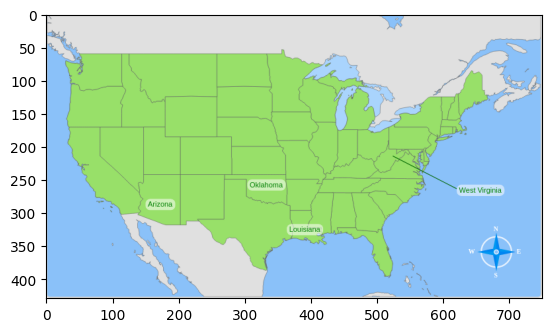

torch.Size([1, 256, 192, 336])


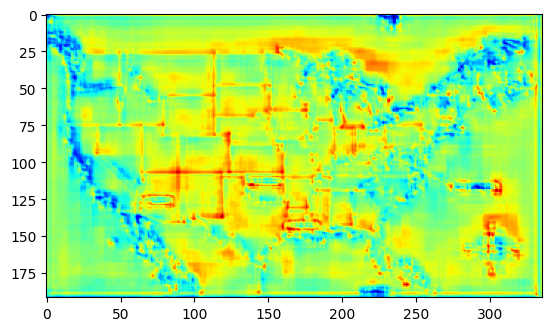

torch.Size([1, 256, 96, 168])


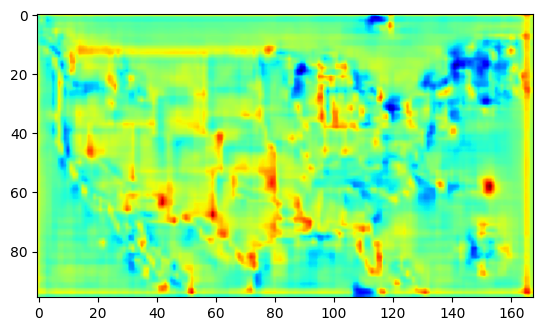

torch.Size([1, 256, 48, 84])


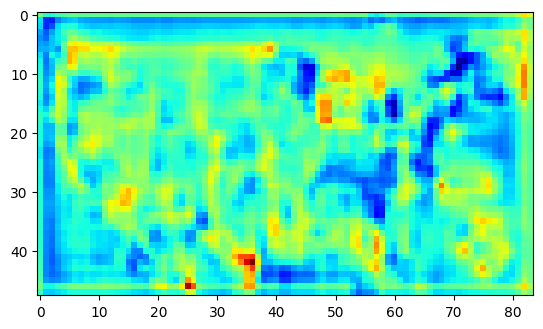

torch.Size([1, 256, 24, 42])


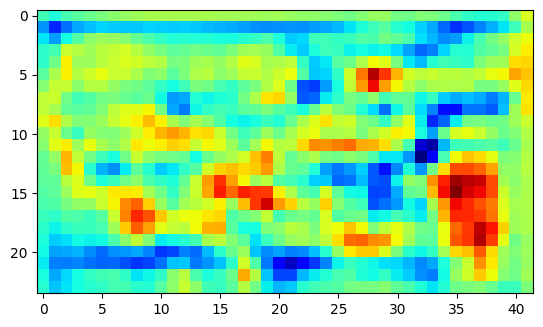

torch.Size([1, 256, 12, 21])


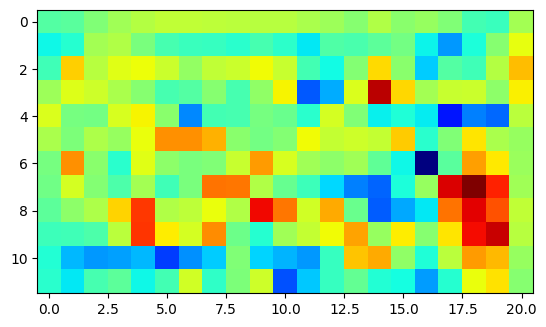

<ipython-input-30-b53bdc1891d5>:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keep = torch.tensor(nms(det_boxes, cls_scores, test_nms_thresh))


In [ ]:
ve_cpu = GetVisualEmbeddings(cfg_path, cuda=False)
plt.imshow(Image.open(BytesIO(train_data.loc[0, 'image']['bytes'])))
plt.show()
example_visual_embeds = ve_cpu.get_visual_embeddings(train_data.head(1), plot=True)

# Inference Example

In [ ]:
from transformers import VisualBertForMultipleChoice

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
vqa_model = VisualBertForMultipleChoice.from_pretrained("uclanlp/visualbert-vcr")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

In [ ]:
question = train_data.loc[0, 'question']
choices = train_data.loc[0, 'choices']
choice_a = choices[0]
choice_b = choices[1]
choice_c = choices[2] # correct answer
choice_d = choices[3]

In [ ]:
print('Question: \n')
print(question)

Question: 

Which of these states is farthest north?


In [ ]:
print('Answer Choices: \n')
print(choice_a)
print(choice_b)
print(choice_c)
print(choice_d)

Answer Choices: 

West Virginia
Louisiana
Arizona
Oklahoma


In [ ]:
# visual_embeds = torch.stack(visual_embeds)
visual_embeds = visual_embeds.reshape(100, 512)

In [ ]:
print(visual_embeds.shape)


torch.Size([100, 512])


In [ ]:
questions = [question]*4
choices = [choice_a, choice_b, choice_c, choice_d]

encoding = tokenizer([(q, c) for q, c in zip(questions, choices)], return_tensors="pt", padding=True)

visual_embeds = visual_embeds.expand(1, 4, *visual_embeds.shape)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
labels = torch.tensor(2).unsqueeze(0)

inputs_dict = {k: v.unsqueeze(0).cuda() for k, v in encoding.items()}
inputs_dict.update(
    {
        "visual_embeds": visual_embeds[0].cuda(),
        "visual_attention_mask": visual_attention_mask.cuda(),
        "visual_token_type_ids": visual_token_type_ids.cuda(),
        "labels": labels.cuda(),
    }
)

vqa_model.cuda()



VisualBertForMultipleChoice(
  (visual_bert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=512, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
     

In [ ]:
outputs = vqa_model(**inputs_dict)

loss = outputs.loss
logits = outputs.logits



In [ ]:
print(logits)

tensor([[1.1943, 1.2253, 1.4653, 1.4727]], device='cuda:0',
       grad_fn=<ViewBackward0>)


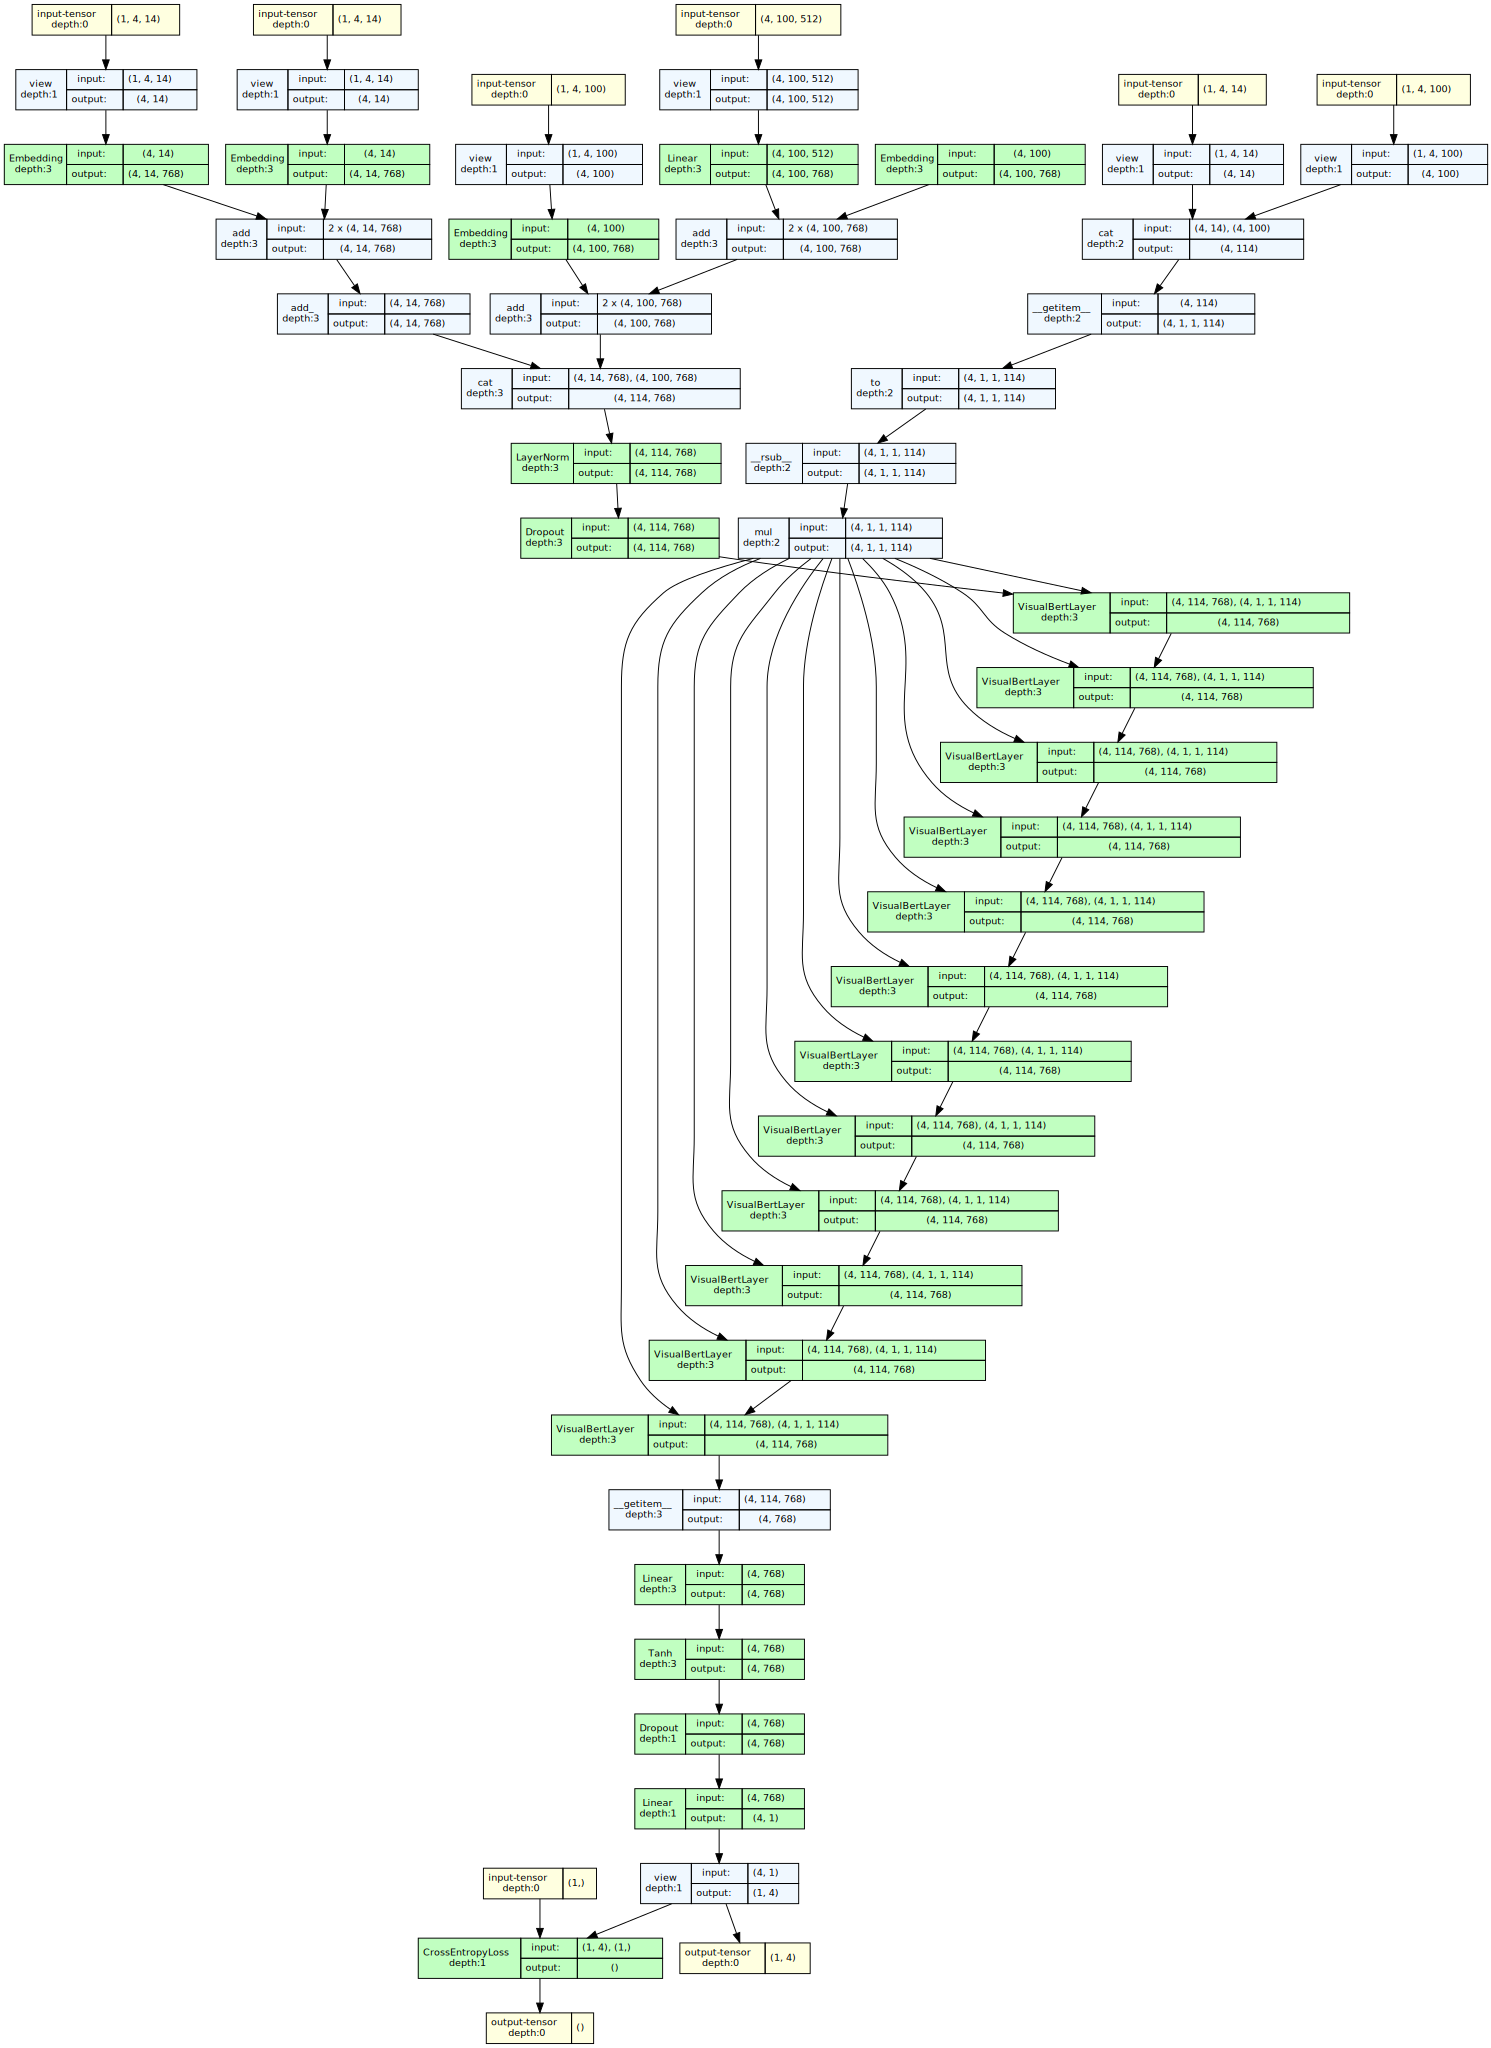

In [ ]:
from torchview import draw_graph


model_graph = draw_graph(vqa_model, input_data=inputs_dict, save_graph=True)
model_graph.visual_graph


# Baseline Model Selection and Justification #

We chose to use the VisualBert for Multiple Choice because it is a model that is already pre-trained on the general downstream task that we are trying to accomplish. Moreover, the model is readily available from Huggingface, with extensive documentation on how to use de model.

Finally, compared to other multimodal models, VisualBert is smaller in size, making it more manageable and easier to train.

In [ ]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(MAX_CHOICES)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_training_dir",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=vqa_model,
    args=training_args,
    train_dataset=tokenized_visual_train,
    eval_dataset=tokenized_visual_validation,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 120.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 51.06 MiB is free. Process 6804 has 14.70 GiB memory in use. Of the allocated memory 13.75 GiB is allocated by PyTorch, and 819.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Results Interpretation and Analysis

Even though me managed to start fine-tuning the model, we were not able to complete the training due to a lack of compute resources. As a team we are still strategizing on how to approach this problem and allocate the necessary resources more efficiently.

Had we completed the training, we would have evaluated the model using accuracy, and we would have compared it to inference done on the ScienceQA dataset by the baseline pre-trained VisualBERT model.


Moreover, another issue we have not yet worked out completely is how to integrate the visual feature extraction into the model training, but we are confident that we are fairly close to solving it.

# Final Model Pipeline Setup


## Data Preprocessing

- **Images:** We'll resize and potentially crop images to a size compatible with our chosen VisualBert model. Careful consideration of whether to crop and focus on specific image regions is important.
- **Image Features:** We'll select an image feature extractor that aligns well with how our VisualBert model was pre-trained. Experimentation with options like ResNet or Faster-RCNN features will help us find the best representation.
- **Text:** We'll use the same tokenizer employed during fine-tuning to ensure compatibility. This will transform the questions and answer choices into input tokens, along with any special tokens required by the model.

## Constructing Model Inputs

- **Batching:** We'll group image-question-choice examples into batches for efficient model training and inference.
- **Input Format:** We'll carefully create an input format that matches the expectations of our VisualBertForMultipleChoice model, including visual embeddings, input tokens, attention masks, and other necessary components.

## Loading the Model

- We'll load our fine-tuned VisualBertForMultipleChoice model, double-checking that it uses the correct weights and configuration.

## Optimization Setup

- **Loss:** We'll likely use cross-entropy loss as it's standard for multiple-choice tasks.
- **Optimizer:** We'll start with AdamW as a solid initial choice but keep other options in mind for potential experimentation.
- **Scheduler:** We might explore a learning rate scheduler with a warmup period to help optimize smoothly.

## Model Training

- **Training Iterations:** We'll carefully determine the number of training epochs, balancing dataset size, convergence, and validation set performance.
- **Regular Validation:** We'll consistently evaluate our model on a held-out validation set to track progress and make sure we aren't overfitting.

## Thorough Evaluation

- **Metrics:** We'll prioritize accuracy as the main metric, potentially supplementing it with others like precision and recall if we want more granular insights.
- **Test Set:** We'll use a separate test set to obtain a realistic assessment of our model's ability to generalize.




# TF Meeting

Since the meeting with Omar our TF, we changed the problem scope to be identifying the correct choice from a set of question-answer pairs. We realized that VisualBERT, while useful for handling multiple choice questions and interpreting the attached images, was not prepared to generate text answers.

Below are the goals for the last milestone:

- Documentation and notebook organization: Curren & Juan Pablo

- Model inference: Udayan

- Performance evaluation: Curren

- Creating the talk track for the video presentation: Juan Pablo